In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np


import matplotlib.pyplot as plt


import os
import cv2

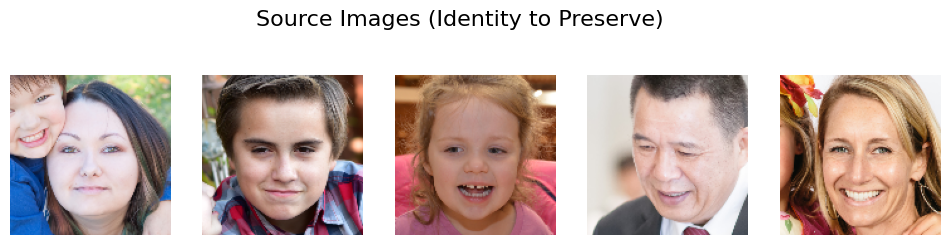

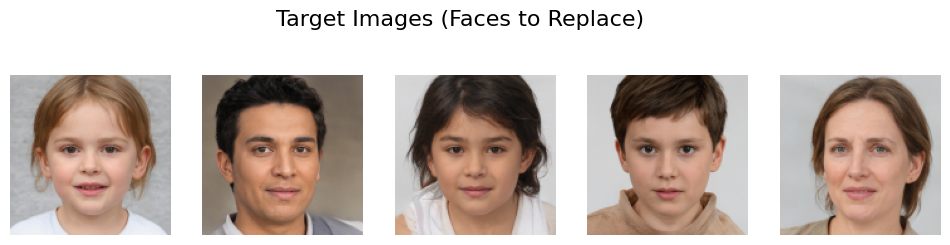

In [2]:

source_data_path = 'Original'  
target_data_path = 'aigenerated'  

# Function to load and preprocess images from a dataset
def load_images(data_path, img_size=(128, 128)):
    images = []
    for filename in os.listdir(data_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(data_path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
                img = cv2.resize(img, img_size)
                images.append(img)
    return np.array(images)

# Load the source and target images
source_images = load_images(source_data_path)
target_images = load_images(target_data_path)

# Normalize pixel values to the range [-1, 1]

source_images = (source_images.astype('float32') - 127.5) / 127.5
target_images = (target_images.astype('float32') - 127.5) / 127.5

# Prepare data batches for training
batch_size = 16  
source_dataset = tf.data.Dataset.from_tensor_slices(source_images).shuffle(buffer_size=1024).batch(batch_size)
target_dataset = tf.data.Dataset.from_tensor_slices(target_images).shuffle(buffer_size=1024).batch(batch_size)

# Display some sample images from both datasets
def show_sample_images(images, title, num_images=5):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title, fontsize=16)
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Convert back to [0, 1] range for display
        img_display = (images[i] * 0.5 + 0.5)
        img_display = np.clip(img_display, 0, 1)
        plt.imshow(img_display)
        plt.axis('off')
    plt.show()

show_sample_images(source_images, "Source Images (Identity to Preserve)")
show_sample_images(target_images, "Target Images (Faces to Replace)")

# Build the Generator Network
Implement the generator network using convolutional layers, batch normalization, and upsampling to create realistic fake images from random noise or source images.

g:\DeepFake\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,782,432 (10.61 MB)

 Trainable params: 2,749,216 (10.49 MB)

 Non-trainable params: 33,216 (129.75 KB)

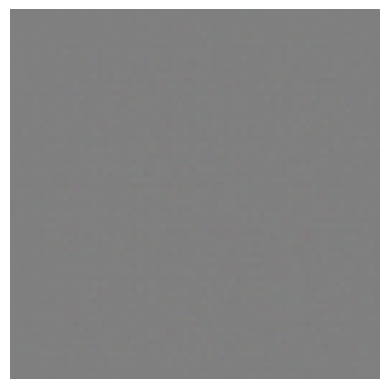

In [3]:
# Build the Generator Network

# Define the generator model
def build_generator():
    model = keras.Sequential()

    # Dense layer to reshape the input noise vector
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape the output to 8x8x256
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    # First upsampling layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second upsampling layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third upsampling layer
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer with tanh activation
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

# Instantiate the generator
generator = build_generator()

# Display the generator model summary
generator.summary()

# Generate a random noise vector
random_noise = tf.random.normal([1, 100])

# Generate a fake image using the generator
generated_image = generator(random_noise, training=False)

# Display the generated image
plt.imshow((generated_image[0] * 0.5 + 0.5).numpy())
plt.axis('off')
plt.show()

# Build the Discriminator Network
Create the discriminator network that will learn to distinguish between real and generated images.

In [4]:
# Build the Discriminator Network

# Define the discriminator model
def build_discriminator():
    model = keras.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third convolutional layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output and add a dense layer for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Instantiate the discriminator
discriminator = build_discriminator()

# Display the discriminator model summary
discriminator.summary()

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Test the discriminator with a real image
real_image = images[0:1]
decision = discriminator(real_image)
print(f"Discriminator decision on real image: {decision}")

# Test the discriminator with a generated image
decision = discriminator(generated_image)
print(f"Discriminator decision on generated image: {decision}")

g:\DeepFake\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'images' is not defined

# Create the GAN Model
Combine the generator and discriminator into a complete GAN architecture and define loss functions for both networks.

In [ ]:
# Create the GAN Model

# Define the GAN model by combining the generator and discriminator
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        random_noise = tf.random.normal([batch_size, 100])

        # Generate fake images
        generated_images = self.generator(random_noise)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Create labels for real and fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate random noise
        random_noise = tf.random.normal([batch_size, 100])

        # Create labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator!)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_noise))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

# Instantiate the GAN model
gan = GAN(generator=generator, discriminator=discriminator)

# Compile the GAN model
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
)

# Define Training Functions
Implement the training loop functions for both the generator and discriminator networks, including gradient calculations and model updates.

In [ ]:
# Define Training Functions

# Function to train the GAN model
def train_gan(gan, dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for real_images in dataset:
            gan.train_step(real_images)

# Set the number of epochs for training
epochs = 50

# Train the GAN model
train_gan(gan, dataset, epochs)

# Train the Model
Execute the training process for the specified number of epochs, saving model checkpoints and sample outputs periodically.

In [ ]:
# Train the Model

# Function to save generated images
def save_generated_images(generator, epoch, num_examples=5, dim=(1, 5), figsize=(10, 2)):
    random_noise = tf.random.normal([num_examples, 100])
    generated_images = generator(random_noise, training=False)
    generated_images = (generated_images * 0.5) + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=figsize)
    for i in range(num_examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
    plt.close()

# Function to train the GAN model with checkpoints
def train_gan_with_checkpoints(gan, dataset, epochs, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for real_images in dataset:
            gan.train_step(real_images)

        # Save model checkpoints
        if (epoch + 1) % 10 == 0:
            gan.generator.save(os.path.join(checkpoint_dir, f"generator_epoch_{epoch + 1}.h5"))
            gan.discriminator.save(os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch + 1}.h5"))

        # Save generated images
        save_generated_images(gan.generator, epoch)

# Set the number of epochs for training
epochs = 50

# Train the GAN model with checkpoints
train_gan_with_checkpoints(gan, dataset, epochs)

# Generate Deepfake Images
Use the trained generator to create deepfake images from test inputs or random noise vectors.

In [ ]:
# Generate Deepfake Images

# Function to generate and display deepfake images
def generate_deepfake_images(generator, num_images=5, noise_dim=100):
    random_noise = tf.random.normal([num_images, noise_dim])
    generated_images = generator(random_noise, training=False)
    generated_images = (generated_images * 0.5) + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Generate and display deepfake images
generate_deepfake_images(generator, num_images=5)

# Evaluate Generated Images
Implement metrics to evaluate the quality of generated images and visualize results with side-by-side comparisons.

In [ ]:
# Evaluate Generated Images

# Function to calculate the mean squared error (MSE) between real and generated images
def calculate_mse(real_images, generated_images):
    return np.mean((real_images - generated_images) ** 2)

# Function to calculate the structural similarity index (SSIM) between real and generated images
def calculate_ssim(real_images, generated_images):
    ssim_values = []
    for real, generated in zip(real_images, generated_images):
        ssim_value = tf.image.ssim(real, generated, max_val=1.0)
        ssim_values.append(ssim_value.numpy())
    return np.mean(ssim_values)

# Function to evaluate the quality of generated images
def evaluate_generated_images(generator, real_images, num_images=5, noise_dim=100):
    # Generate fake images
    random_noise = tf.random.normal([num_images, noise_dim])
    generated_images = generator(random_noise, training=False)
    generated_images = (generated_images * 0.5) + 0.5  # Rescale to [0, 1]

    # Select a subset of real images for comparison
    real_images_subset = real_images[:num_images]

    # Calculate evaluation metrics
    mse = calculate_mse(real_images_subset, generated_images)
    ssim = calculate_ssim(real_images_subset, generated_images)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Structural Similarity Index (SSIM): {ssim}")

    # Visualize real and generated images side-by-side
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Display real image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images_subset[i])
        plt.axis('off')
        plt.title("Real")

        # Display generated image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title("Generated")
    plt.show()

# Evaluate the generated images
evaluate_generated_images(generator, images, num_images=5)